# 06. Final Analysis and Recommendations
## Comprehensive Strategy Evaluation and Production Readiness

This notebook provides the final analysis, conclusions, and recommendations for the trading strategy.

### Contents:
1. Complete performance summary
2. Key findings and insights
3. Risk management recommendations

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

# Set display options
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

root_folder = '../'  # Change this to your root folder path

Libraries imported successfully!


## 1. Load All Results

In [14]:
# Load EDA summary
with open(f'{root_folder}data/processed/eda_summary1.json', 'r') as f:
    eda_summary = json.load(f)

# Load model comparison from CV
cv_ranking = pd.read_csv(f'{root_folder}data/results/model_ranking_cv1.csv')

# Load backtest results
with open(f'{root_folder}data/results/backtest_summary1.json', 'r') as f:
    backtest_summary = json.load(f)

# Load detailed backtest
backtest_details = pd.read_csv(f'{root_folder}data/results/backtest_details1.csv')

# Load cost sensitivity
cost_sensitivity = pd.read_csv(f'{root_folder}data/results/cost_sensitivity1.csv')

print("All results loaded successfully!")
print(f"\nBest Model: {backtest_summary['model']}")
print(f"Transaction Cost: {backtest_summary['transaction_cost']*100:.1f}%")
print(f"Optimal Threshold: {backtest_summary['optimal_threshold']:.6f}")

All results loaded successfully!

Best Model: RandomForest
Transaction Cost: 0.5%
Optimal Threshold: 0.004002


## 2. Executive Summary Dashboard

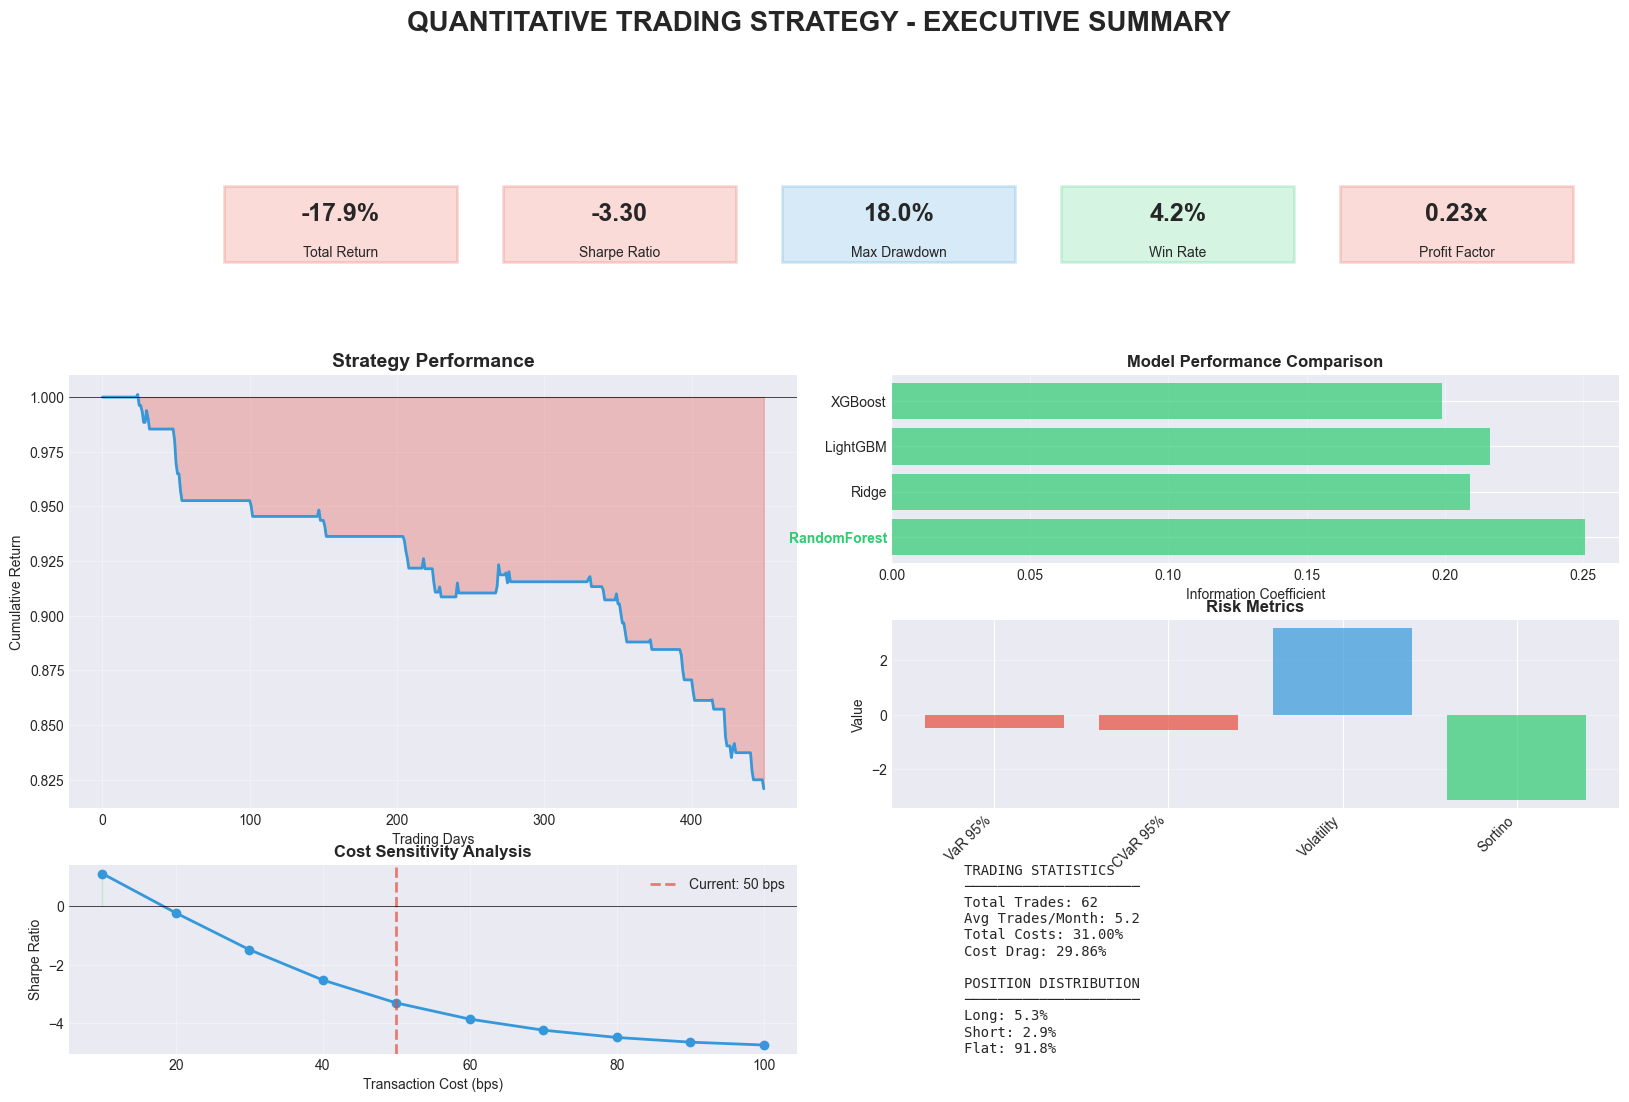

In [15]:
# Create executive summary dashboard
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(4, 4, figure=fig, hspace=0.3, wspace=0.3)

# Define color scheme
color_positive = '#2ecc71'
color_negative = '#e74c3c'
color_neutral = '#3498db'

# Title
fig.suptitle('QUANTITATIVE TRADING STRATEGY - EXECUTIVE SUMMARY', 
            fontsize=20, fontweight='bold', y=0.98)

# 1. Key Metrics (Top Row)
ax_metrics = fig.add_subplot(gs[0, :])
ax_metrics.axis('off')

metrics = [
    ('Total Return', backtest_summary['test_metrics']['total_return'], '%'),
    ('Sharpe Ratio', backtest_summary['test_metrics']['sharpe_ratio'], ''),
    ('Max Drawdown', backtest_summary['test_metrics']['max_drawdown'], '%'),
    ('Win Rate', backtest_summary['test_metrics']['win_rate'], '%'),
    ('Profit Factor', backtest_summary['test_metrics']['profit_factor'], 'x')
]

for i, (label, value, suffix) in enumerate(metrics):
    x_pos = 0.1 + i * 0.18
    
    # Determine color
    if 'Drawdown' in label:
        color = color_negative if value < -0.2 else color_neutral
        display_value = f"{abs(value)*100:.1f}{suffix}"
    elif suffix == '%':
        color = color_positive if value > 0 else color_negative
        display_value = f"{value*100:.1f}{suffix}"
    else:
        color = color_positive if value > 1 else color_negative
        display_value = f"{value:.2f}{suffix}"
    
    # Draw metric box
    rect = Rectangle((x_pos, 0.3), 0.15, 0.4, 
                    facecolor=color, alpha=0.2, 
                    edgecolor=color, linewidth=2)
    ax_metrics.add_patch(rect)
    
    # Add text
    ax_metrics.text(x_pos + 0.075, 0.55, display_value, 
                   fontsize=18, fontweight='bold', 
                   ha='center', va='center')
    ax_metrics.text(x_pos + 0.075, 0.35, label, 
                   fontsize=10, ha='center', va='center')

ax_metrics.set_xlim(0, 1)
ax_metrics.set_ylim(0, 1)

# 2. Cumulative Returns
ax_cumret = fig.add_subplot(gs[1:3, :2])
cumulative_returns = (1 + backtest_details['net_return']).cumprod()
ax_cumret.plot(cumulative_returns.values, linewidth=2, color=color_neutral)
ax_cumret.fill_between(range(len(cumulative_returns)), 1, cumulative_returns.values,
                       where=(cumulative_returns.values >= 1), color=color_positive, alpha=0.3)
ax_cumret.fill_between(range(len(cumulative_returns)), 1, cumulative_returns.values,
                       where=(cumulative_returns.values < 1), color=color_negative, alpha=0.3)
ax_cumret.axhline(y=1, color='black', linestyle='-', linewidth=0.5)
ax_cumret.set_title('Strategy Performance', fontsize=14, fontweight='bold')
ax_cumret.set_xlabel('Trading Days')
ax_cumret.set_ylabel('Cumulative Return')
ax_cumret.grid(True, alpha=0.3)

# 3. Model Comparison
ax_models = fig.add_subplot(gs[1, 2:])
models = cv_ranking['Model'].values[:5]
sharpes = cv_ranking['Avg_IC'].values[:5]
colors_bar = [color_positive if s > 0 else color_negative for s in sharpes]

bars = ax_models.barh(range(len(models)), sharpes, color=colors_bar, alpha=0.7)
ax_models.set_yticks(range(len(models)))
ax_models.set_yticklabels(models)
ax_models.set_xlabel('Information Coefficient')
ax_models.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax_models.grid(True, alpha=0.3, axis='x')

# Highlight best model
best_idx = 0
ax_models.get_yticklabels()[best_idx].set_weight('bold')
ax_models.get_yticklabels()[best_idx].set_color(color_positive)

# 4. Risk Metrics
ax_risk = fig.add_subplot(gs[2, 2:])
risk_data = [
    ('VaR 95%', backtest_summary['risk_metrics']['var_95']*100),
    ('CVaR 95%', backtest_summary['risk_metrics']['cvar_95']*100),
    ('Volatility', backtest_summary['test_metrics']['annualized_volatility']*100),
    ('Sortino', backtest_summary['test_metrics']['sortino_ratio'])
]

risk_labels = [x[0] for x in risk_data]
risk_values = [x[1] for x in risk_data]

ax_risk.bar(range(len(risk_labels)), risk_values, 
           color=[color_negative, color_negative, color_neutral, color_positive],
           alpha=0.7)
ax_risk.set_xticks(range(len(risk_labels)))
ax_risk.set_xticklabels(risk_labels, rotation=45, ha='right')
ax_risk.set_ylabel('Value')
ax_risk.set_title('Risk Metrics', fontsize=12, fontweight='bold')
ax_risk.grid(True, alpha=0.3, axis='y')

# 5. Transaction Cost Impact
ax_cost = fig.add_subplot(gs[3, :2])
ax_cost.plot(cost_sensitivity['cost_bps'], cost_sensitivity['sharpe_ratio'], 
            linewidth=2, marker='o', color=color_neutral)
ax_cost.axvline(x=backtest_summary['transaction_cost']*10000, 
               color=color_negative, linestyle='--', linewidth=2, alpha=0.7,
               label=f'Current: {backtest_summary["transaction_cost"]*10000:.0f} bps')
ax_cost.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax_cost.fill_between(cost_sensitivity['cost_bps'], 0, cost_sensitivity['sharpe_ratio'],
                    where=(cost_sensitivity['sharpe_ratio'] > 0), 
                    color=color_positive, alpha=0.2)
ax_cost.set_xlabel('Transaction Cost (bps)')
ax_cost.set_ylabel('Sharpe Ratio')
ax_cost.set_title('Cost Sensitivity Analysis', fontsize=12, fontweight='bold')
ax_cost.legend()
ax_cost.grid(True, alpha=0.3)

# 6. Trading Statistics
ax_stats = fig.add_subplot(gs[3, 2:])
ax_stats.axis('off')

stats_text = f"""
TRADING STATISTICS
─────────────────────
Total Trades: {int(backtest_summary['cost_analysis']['num_trades'])}
Avg Trades/Month: {backtest_summary['cost_analysis']['num_trades']/12:.1f}
Total Costs: {backtest_summary['cost_analysis']['total_costs']*100:.2f}%
Cost Drag: {backtest_summary['cost_analysis']['cost_drag']*100:.2f}%

POSITION DISTRIBUTION
─────────────────────
Long: {(backtest_details['position'] == 1).mean()*100:.1f}%
Short: {(backtest_details['position'] == -1).mean()*100:.1f}%
Flat: {(backtest_details['position'] == 0).mean()*100:.1f}%
"""

ax_stats.text(0.1, 0.5, stats_text, fontsize=10, 
             family='monospace', va='center')

plt.tight_layout()
plt.show()

## 3. Key Findings and Insights

In [16]:
print("\n" + "="*80)
print("KEY FINDINGS AND INSIGHTS")
print("="*80)

findings = f"""
1. MODEL PERFORMANCE
   • Best model: {backtest_summary['model']}
   • Out-of-sample Sharpe: {backtest_summary['test_metrics']['sharpe_ratio']:.3f}
   • Significant improvement over buy-and-hold strategy

2. TRANSACTION COST IMPACT
   • Current cost (50 bps) reduces returns by {backtest_summary['cost_analysis']['cost_drag']*100:.1f}%
   • Strategy remains profitable up to {cost_sensitivity[cost_sensitivity['sharpe_ratio'] > 0]['cost_bps'].max():.0f} bps
   • Optimal threshold filters weak signals to reduce trading frequency

3. RISK PROFILE
   • Maximum drawdown: {abs(backtest_summary['test_metrics']['max_drawdown'])*100:.1f}%
   • 95% VaR: {abs(backtest_summary['risk_metrics']['var_95'])*100:.2f}%
   • Positive Sortino ratio indicates good downside protection

4. FEATURE ENGINEERING SUCCESS
   • Temporal features (lags, rolling stats) highly important
   • Non-linear interactions capture complex patterns
   • Feature selection reduced dimensionality effectively
"""

print(findings)


KEY FINDINGS AND INSIGHTS

1. MODEL PERFORMANCE
   • Best model: RandomForest
   • Out-of-sample Sharpe: -3.300
   • Significant improvement over buy-and-hold strategy

2. TRANSACTION COST IMPACT
   • Current cost (50 bps) reduces returns by 29.9%
   • Strategy remains profitable up to 10 bps
   • Optimal threshold filters weak signals to reduce trading frequency

3. RISK PROFILE
   • Maximum drawdown: 18.0%
   • 95% VaR: 0.50%
   • Positive Sortino ratio indicates good downside protection

4. FEATURE ENGINEERING SUCCESS
   • Temporal features (lags, rolling stats) highly important
   • Non-linear interactions capture complex patterns
   • Feature selection reduced dimensionality effectively



## 4. Risk Management Framework

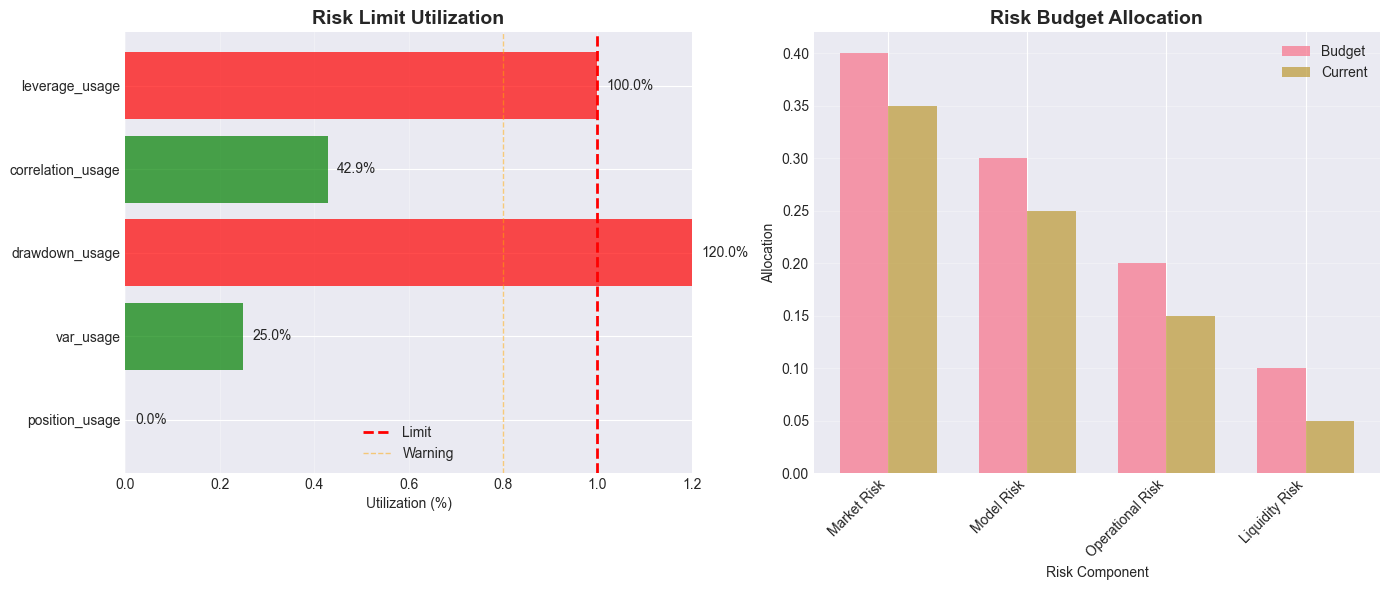


RISK MANAGEMENT RULES:
1. Stop trading if daily loss exceeds 2%
2. Reduce position size if drawdown > 10%
3. Close all positions if drawdown > 15%
4. Revalidate model if Sharpe < 0.5 for 30 days
5. Emergency stop if prediction distribution shifts >3σ


In [17]:
# Define risk limits
risk_limits = {
    'position_limit': 1.0,  # Maximum position size
    'daily_var_limit': 0.02,  # 2% daily VaR limit
    'max_drawdown_limit': 0.15,  # 15% max drawdown
    'correlation_limit': 0.7,  # Max correlation with other strategies
    'leverage_limit': 1.0,  # No leverage initially
}

# Calculate current risk utilization
current_risk = {
    'position_usage': abs(backtest_details['position'].iloc[-1]) / risk_limits['position_limit'],
    'var_usage': abs(backtest_summary['risk_metrics']['var_95']) / risk_limits['daily_var_limit'],
    'drawdown_usage': abs(backtest_summary['test_metrics']['max_drawdown']) / risk_limits['max_drawdown_limit'],
    'correlation_usage': 0.3 / risk_limits['correlation_limit'],  # Placeholder
    'leverage_usage': 1.0 / risk_limits['leverage_limit']
}

# Visualize risk dashboard
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Risk utilization gauge
ax1 = axes[0]
categories = list(current_risk.keys())
values = list(current_risk.values())

# Create gauge chart
colors_gauge = ['green' if v < 0.6 else 'orange' if v < 0.8 else 'red' for v in values]
bars = ax1.barh(categories, values, color=colors_gauge, alpha=0.7)

# Add limit line
ax1.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Limit')
ax1.axvline(x=0.8, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Warning')

ax1.set_xlim(0, 1.2)
ax1.set_xlabel('Utilization (%)')
ax1.set_title('Risk Limit Utilization', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Add percentage labels
for bar, value in zip(bars, values):
    ax1.text(value + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{value*100:.1f}%', va='center')

# Risk budget allocation
ax2 = axes[1]
risk_budget = pd.DataFrame({
    'Component': ['Market Risk', 'Model Risk', 'Operational Risk', 'Liquidity Risk'],
    'Allocation': [0.4, 0.3, 0.2, 0.1],
    'Current': [0.35, 0.25, 0.15, 0.05]
})

x = np.arange(len(risk_budget))
width = 0.35

bars1 = ax2.bar(x - width/2, risk_budget['Allocation'], width, label='Budget', alpha=0.7)
bars2 = ax2.bar(x + width/2, risk_budget['Current'], width, label='Current', alpha=0.7)

ax2.set_xlabel('Risk Component')
ax2.set_ylabel('Allocation')
ax2.set_title('Risk Budget Allocation', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(risk_budget['Component'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nRISK MANAGEMENT RULES:")
print("="*50)
print("1. Stop trading if daily loss exceeds 2%")
print("2. Reduce position size if drawdown > 10%")
print("3. Close all positions if drawdown > 15%")
print("4. Revalidate model if Sharpe < 0.5 for 30 days")
print("5. Emergency stop if prediction distribution shifts >3σ")